# Treemix Ag1000G phase2
For build a dataset Treemix I need unlinked SNPs. So I have to prune my allele count datasets to obtain SNPs in high LD.
For doing this I need:
    - Phase2 Genotype callset
    - Phase2 Allele count
    - Outgroup Allele count

In this notebook I edited an old Alistair's notebook of the Phase1 of Ag1000G (<b>20151001 treemix prep 4</b>). On my phase2 datasets I have already the biallelic allele counts so I skipped the searching and filtering for biallelic SNPs

Import my modules:

In [27]:
%run local_imports.ipynb

Import callsets:

In [28]:
callset_pass= zarr.open('/mnt/70D89269D8922CFA/Genomes/variation/ag1000g.phase2.ar1.pass.biallelic/')
allele_counts= zarr.open('/mnt/70D89269D8922CFA/Genomes/extras/phase2_biallel_allele_count.zarr/')
outgroup_allele_counts= zarr.open('/mnt/70D89269D8922CFA/Genomes/extras/outgroup_alleles_phase2.zarr/')

------------------------

Define functions to locate biallelic allele counts on a range for my outgroup and phase2 datasets:

In [41]:
def outgroup_ascertainment(chrom, start, stop, outgroups):
    
    # locate region
    pos = allel.SortedIndex(callset_pass[chrom]['variants']['POS'][:])
    locr = pos.locate_range(start, stop)
    
    # ascertain SNPs
    loca = np.zeros(pos.shape, dtype='b1')
    loca[locr] = True
    log('outgroup ascertainment, initial', nnz(loca))
    for s in outgroups:
        ac = allel.AlleleCountsArray(outgroup_allele_counts[chrom][s][:])
        # non-missing
        locs = (ac.sum(axis=1) > 0)
        loca &= locs
        log(s, nnz(loca))
        
    return loca
        

In [42]:
def ingroup_ascertainment(chrom, start, stop, segpops):

    # locate region
    pos = allel.SortedIndex(callset_pass[chrom]['variants']['POS'][:])
    locr = pos.locate_range(start, stop)

    # ascertain SNPs
    loca = np.zeros(pos.shape, dtype='b1')
    loca[locr] = True
    log('ingroup ascertainment, initial', nnz(loca))

    
    # require segregating
    for pop in segpops:
        ac = allel.AlleleCountsArray(allele_counts[chrom][pop][:])
        loc_seg = ac.min(axis=1) > 0
        loca &= loc_seg
        log('after require segregating in', pop, nnz(loca))
        
    return loca

Define function for ld pruning. LD-pruning remove SNPs with an high correlation. Using windows this function compute pairwise LD between all SNPs within each window, then removing one SNP from each correlated pair.

In [43]:
def ld_prune(pos, gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        log('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
        pos = pos.compress(loc_unlinked)
    return pos, gn

Define function for generating treemix file:

In [44]:
def to_treemix(acs, fn):
    pops = sorted(acs.keys())
    n_variants = acs[pops[0]].shape[0]
    n_alleles = acs[pops[0]].shape[1]
    assert n_alleles == 2, 'only biallelic variants supported'
    for pop in pops[1:]:
        assert n_variants == acs[pop].shape[0], 'bad number of variants for pop %s' % pop
        assert n_alleles == acs[pop].shape[1], 'bad number of alleles for pop %s' % pop
        
    with open(fn, 'wt', encoding='ascii') as f:
        print(' '.join(pops), file=f)
        for i in range(n_variants):
            print(' '.join([','.join(map(str, acs[pop][i])) for pop in pops]), file=f)


Define a new function that randomly downsample if I have a large dataset and applies ld-pruning on it:

In [45]:
def downsample_and_prune(chrom, start, stop, loc_asc,
                         n=100000, ldp_size=500, ldp_step=250, ldp_threshold=.1, ldp_n_iter=1):

    # all variant positions
    pos = allel.SortedIndex(callset_pass[chrom]['variants']['POS'][:])
    posa = pos[loc_asc]

    # randomly downsample
    if n < posa.shape[0]:
        posds = np.random.choice(posa, n, replace=False)
        posds.sort()
        posds = allel.SortedIndex(posds)
    else:
        # skip downsampling
        posds = posa
    locds = pos.locate_keys(posds)    

    # load genotype data
    genotype = allel.GenotypeChunkedArray(callset_pass[chrom]['calldata/GT'])
    geno_subset = genotype.subset(sel0=loc_asc)
    gn = geno_subset.to_n_alt()
    
    # prune
    posu, gnu = ld_prune(posds, gn, size=ldp_size, step=ldp_step, threshold=ldp_threshold, n_iter=ldp_n_iter)
    locu = pos.locate_keys(posu)
    
    return locu

Define last function, the analysis function that includes all function below and applies these on my populations, outgroups, chromosomes of interest.

In [46]:
def run_analysis(rname, chrom, start, stop, outgroups, segpops,
                 n=100000, ldp_size=500, ldp_step=250, ldp_threshold=.1, ldp_n_iter=1):

    # initial ascertainment
    loc_og_asc = outgroup_ascertainment(chrom, start, stop, outgroups=outgroups)
    loc_ig_asc = ingroup_ascertainment(chrom, start, stop, segpops=segpops)
    loc_asc = loc_og_asc & loc_ig_asc
    log('initial ascertainment', nnz(loc_asc))
    
    # downsample and prune
    locu = downsample_and_prune(chrom, start, stop, loc_asc, 
                                n=n, ldp_size=ldp_size, ldp_step=ldp_step, 
                                ldp_threshold=ldp_threshold, ldp_n_iter=ldp_n_iter)
    
    # write allele counts
    acsu = dict()
    for pop in populations:
        acsu[pop] = allele_counts[chrom][pop][:, :2][locu]
    for pop in outgroups:
        acsu[pop] = outgroup_allele_counts[chrom][pop][:, :2][locu]

    outdir = 'd/data/treemix/seg_%s_og_%s_ldp_%s' % ('_'.join(segpops), '_'.join(outgroups), ldp_n_iter)
    !mkdir -pv {outdir}
    fn = os.path.join(outdir, '%s.allele_counts.txt' % rname)
    to_treemix(acsu, fn)
    !gzip -fv {fn}


Declaring values for generating my treemix file and ran on it for chromosome 3R, 3L, X, and the X region involved on speciation between <i>An.gambiae</i> and <i>An.coluzzii</i>

In [47]:
outgroups = ['arab', 'quad', 'meru', 'mela', 'chri']
segpops = ['AOcol', 'BFcol', 'CIcol', 'GHcol', 'GNcol','GHgam', 'CMgam', 'BFgam', 'GNgam', 'GQgam', 'UGgam', 'GAgam', 'FRgam','KE', 'GM', 'GW']
n = 200000
ldp_n_iter = 1
region_X_speciation = 'X-speciation', 'X', 15000000, 24000000 
region_X_free = 'X-free', 'X', 1, 14000000 
region_3L_free = '3L-free', '3L', 15000000, 41000000
region_3R_free = '3R-free', '3R', 1, 37000000 

In [52]:
rname, chrom, start, stop = region_3L_free
log(rname, chrom, start, stop)
run_analysis(rname, chrom, start, stop, outgroups, segpops, n=n, ldp_n_iter=ldp_n_iter)

3L-free 3L 15000000 41000000
outgroup ascertainment, initial 5989818
arab 5798549
quad 5631869
meru 5508665
mela 5237625
chri 3579558
ingroup ascertainment, initial 5989818
after require segregating in AOcol 672596
after require segregating in BFcol 448836
after require segregating in CIcol 392968
after require segregating in GHcol 368591
after require segregating in GNcol 190540
after require segregating in GHgam 168923
after require segregating in CMgam 168833
after require segregating in BFgam 168532
after require segregating in GNgam 167228
after require segregating in GQgam 146236
after require segregating in UGgam 146178
after require segregating in GAgam 142414
after require segregating in FRgam 96294
after require segregating in KE 68187
after require segregating in GM 68141
after require segregating in GW 68139
initial ascertainment 35421
iteration 1 retaining 27609 removing 7812 variants
data/treemix/seg_AOcol_BFcol_CIcol_GHcol_GNcol_GHgam_CMgam_BFgam_GNgam_GQgam_UGgam_GAgam_

In [ ]:
rname, chrom, start, stop = region_3R_free
log(rname, chrom, start, stop)
run_analysis(rname, chrom, start, stop, outgroups, segpops,n=n, ldp_n_iter=ldp_n_iter)

3R-free 3R 1 37000000
outgroup ascertainment, initial 8535400
arab 10276349
quad 10097686
meru 10085344
mela 9872425
chri 7172914
ingroup ascertainment, initial 8535400
after require segregating in AOcol 1209686
after require segregating in BFcol 3201821
after require segregating in CIcol 2464295
after require segregating in GHcol 2264357
after require segregating in GNcol 622728
after require segregating in GHgam 1336110
after require segregating in CMgam 6052532
after require segregating in BFgam 3754716
after require segregating in GNgam 2578564
after require segregating in GQgam 1013772
after require segregating in UGgam 3647615
after require segregating in GAgam 1635111
after require segregating in FRgam 630167
after require segregating in KE 530292
after require segregating in GM 2327947
after require segregating in GW 3384404
initial ascertainment 2178245


In [53]:
rname, chrom, start, stop = region_X_free
log(rname, chrom, start, stop)
run_analysis(rname, chrom, start, stop, outgroups, segpops, n=n, ldp_n_iter=ldp_n_iter)

X-free X 1 14000000
outgroup ascertainment, initial 3357129
arab 2723145
quad 2558263
meru 2437057
mela 2210408
chri 951454
ingroup ascertainment, initial 3357129
after require segregating in AOcol 283965
after require segregating in BFcol 173888
after require segregating in CIcol 146215
after require segregating in GHcol 135601
after require segregating in GNcol 55134
after require segregating in GHgam 48802
after require segregating in CMgam 48790
after require segregating in BFgam 48695
after require segregating in GNgam 48384
after require segregating in GQgam 40476
after require segregating in UGgam 40466
after require segregating in GAgam 38465
after require segregating in FRgam 16632
after require segregating in KE 9986
after require segregating in GM 9980
after require segregating in GW 9980
initial ascertainment 1976
iteration 1 retaining 1794 removing 182 variants
data/treemix/seg_AOcol_BFcol_CIcol_GHcol_GNcol_GHgam_CMgam_BFgam_GNgam_GQgam_UGgam_GAgam_FRgam_KE_GM_GW_og_arab_q

In [54]:
rname, chrom, start, stop = region_X_speciation
log(rname, chrom, start, stop)
run_analysis(rname, chrom, start, stop, outgroups, segpops, n=n, ldp_n_iter=ldp_n_iter)

X-speciation X 15000000 24000000
outgroup ascertainment, initial 883199
arab 666309
quad 634440
meru 604703
mela 572721
chri 220762
ingroup ascertainment, initial 883199
after require segregating in AOcol 54420
after require segregating in BFcol 22465
after require segregating in CIcol 18595
after require segregating in GHcol 17516
after require segregating in GNcol 7051
after require segregating in GHgam 2757
after require segregating in CMgam 2734
after require segregating in BFgam 2634
after require segregating in GNgam 2549
after require segregating in GQgam 1574
after require segregating in UGgam 1570
after require segregating in GAgam 1331
after require segregating in FRgam 553
after require segregating in KE 350
after require segregating in GM 347
after require segregating in GW 347
initial ascertainment 73
iteration 1 retaining 37 removing 36 variants
data/treemix/seg_AOcol_BFcol_CIcol_GHcol_GNcol_GHgam_CMgam_BFgam_GNgam_GQgam_UGgam_GAgam_FRgam_KE_GM_GW_og_arab_quad_meru_mela_c

## Treemix

Total SNPs per chromosomes:
- <b>3L-free</b>: 27609 SNPs
- <b>3R-free</b>: 40187 SNPs
- <b>X-free</b>: 1794 SNPs
- <b>X-speciation</b>: 37 SNPs

I ran treemix using as option bootstrap -k 500 and represented in R with  `plot_tree function`

In [2]:
from IPython.display import Image

### 3L-free

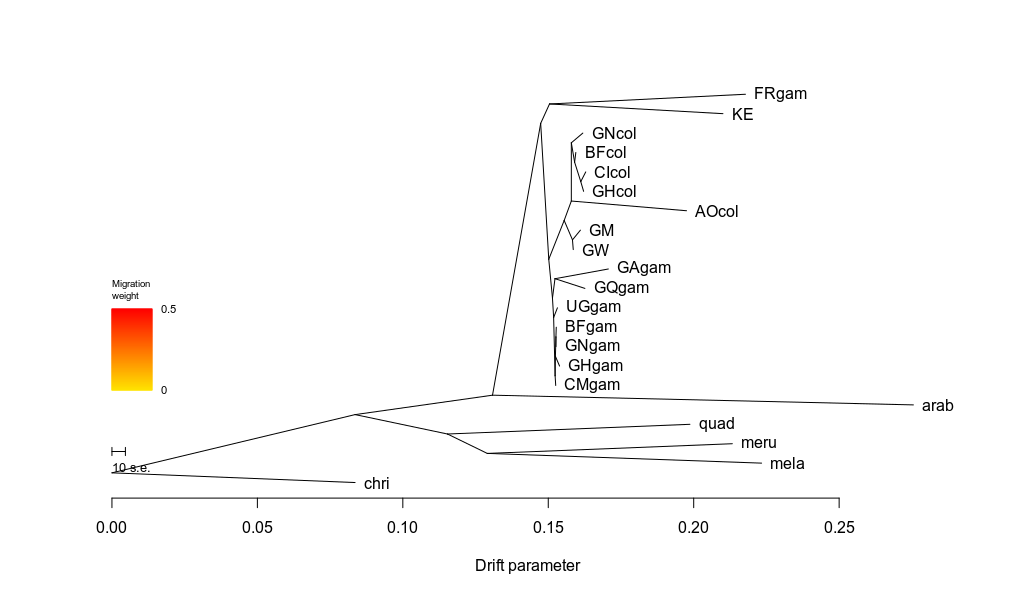

In [3]:
Image(filename='/home/randomx/Dropbox/Ag1000G_carlo/notebooks/images/treemix/3L_free.png')

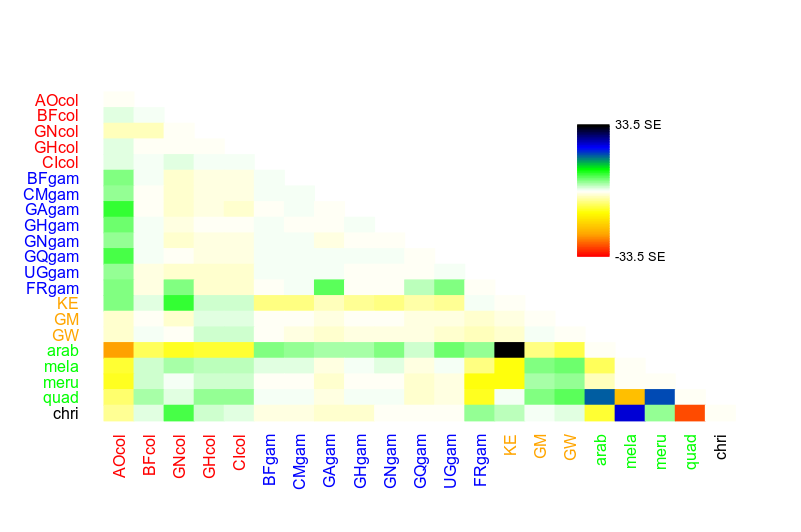

In [3]:
Image(filename='/home/randomx/Dropbox/Ag1000G_carlo/notebooks/images/treemix/3L-free_residuals.png')

### 3R-free

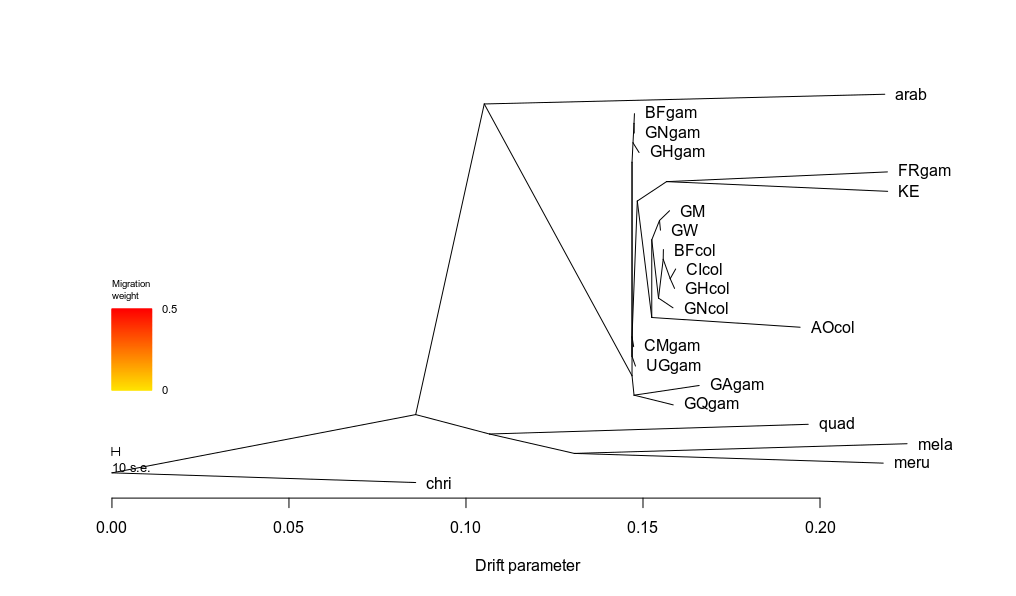

In [4]:
Image(filename='/home/randomx/Dropbox/Ag1000G_carlo/notebooks/images/treemix/3R_free.png')

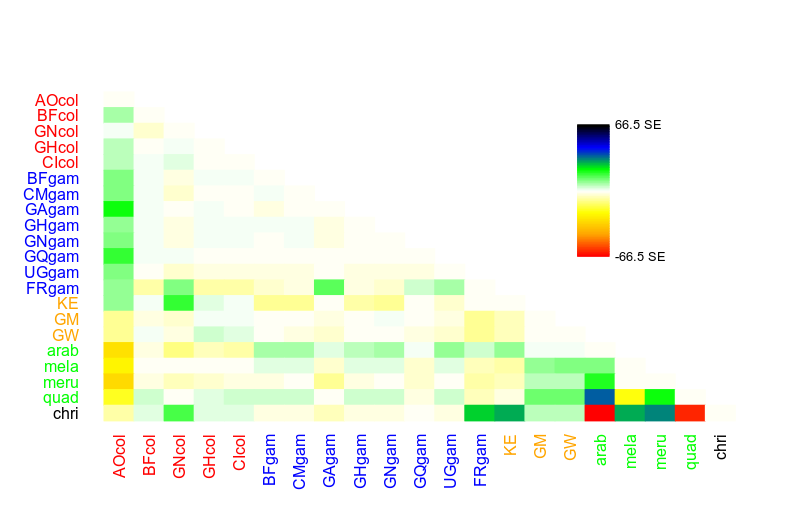

In [4]:
Image(filename='/home/randomx/Dropbox/Ag1000G_carlo/notebooks/images/treemix/3R-free_residuals.png')

### X-free

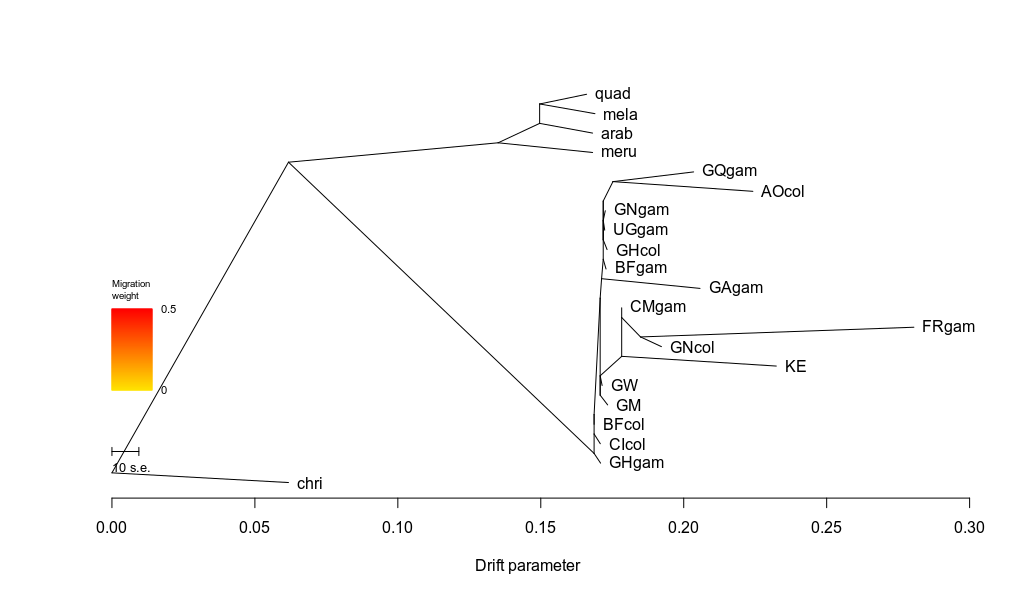

In [5]:
Image(filename='/home/randomx/Dropbox/Ag1000G_carlo/notebooks/images/treemix/X_free.png')

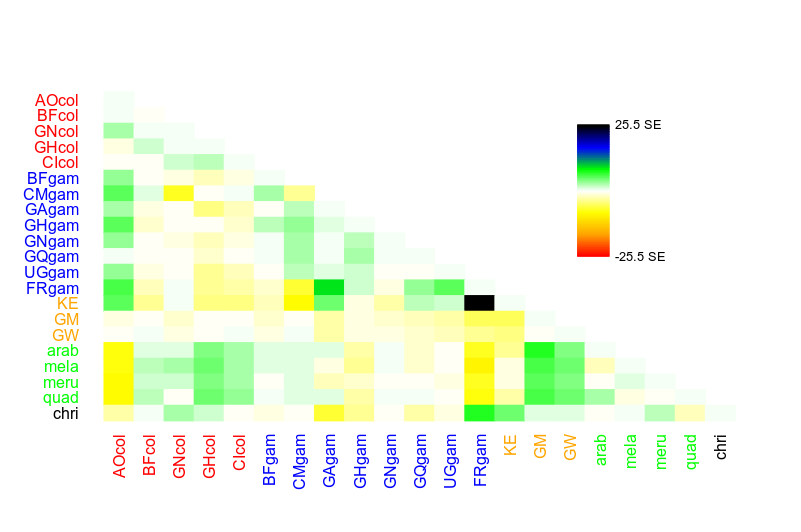

In [5]:
Image(filename='/home/randomx/Dropbox/Ag1000G_carlo/notebooks/images/treemix/X-free_residuals.png')

### X-speciation

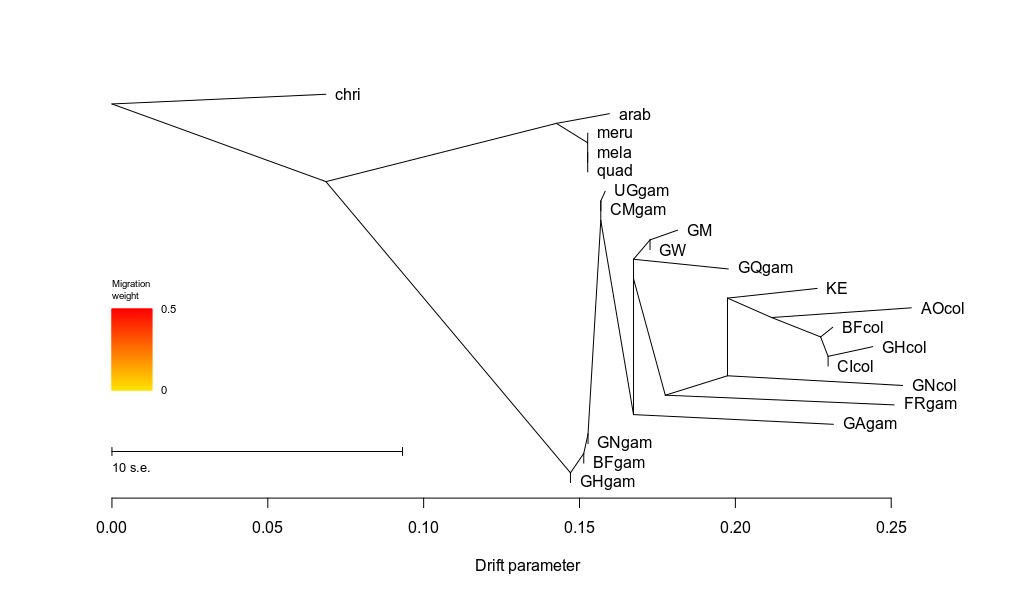

In [6]:
Image(filename='/home/randomx/Dropbox/Ag1000G_carlo/notebooks/images/treemix/X_speciation.png')

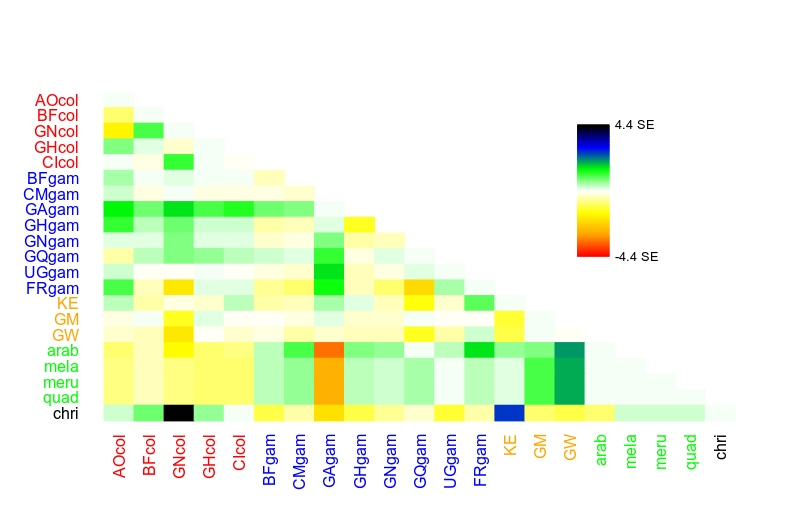

In [7]:
Image(filename='/home/randomx/Dropbox/Ag1000G_carlo/notebooks/images/treemix/X_speciation_residuals.png')